# Patch Size as Connectivity

We analyze how well patch size would work as connectivity measure.

## Code Setup

In [1]:
# Path to main directory
LOCAL_PATH = "data/CA-Final"
DATA_PATH = LOCAL_PATH

In [2]:
import os
import pandas as pd
import numpy as np
import sys
from IPython.core.display import HTML

In [3]:
sys.path.append(os.path.join(os.getcwd(), "birdmaps"))
from birdmaps import bird_runs

## Bird Run Definition

In [4]:
bird_run = bird_runs.BirdRun(DATA_PATH)

In [5]:
def wmean(x, w):
    """Weighted Mean"""
    return np.sum(x * w) / np.sum(w)

def wcov(x, y, w):
    """Weighted Covariance"""
    return np.sum(w * (x - wmean(x, w)) * (y - wmean(y, w))) / np.sum(w)

def wcorr(x, y, w):
    """Weighted Correlation"""
    return wcov(x, y, w) / np.sqrt(wcov(x, x, w) * wcov(y, y, w))

In [6]:
import matplotlib.pyplot as plt
from matplotlib import cm
import colorcet
from scipy import stats
from sklearn.linear_model import LinearRegression


In [11]:
def plot_bird_ratios_locations(bird, max_checklists=100):
    bird_name = bird.name
    df = pd.read_csv(bird.obs_csv_path)
    # limit to squares where max hab > 0.9
    df = df.loc[lambda r : r["max_hab"] > 0.9]
    df = df.loc[lambda r : r["NumChecklists"] <= max_checklists]
    print("Number of loactions:", len(df))
    df["MaxRepopRange"] = df.apply(lambda row : int(row["max_repop"] * 9.999) / 10, axis=1)
    sizes = np.array(df.groupby("MaxRepopRange")["Square"].count()) # Counts the locations. 
    ys = np.array(df.groupby("MaxRepopRange")["BirdRatio"].mean())
    xs = np.array(list(df.groupby("MaxRepopRange")["BirdRatio"].indices.keys()))
    corr = wcorr(xs, ys, sizes)
    print("Correlation:", corr)
    reg = LinearRegression().fit(xs.reshape(-1, 1), ys.reshape(-1, 1), sizes)
    r_square = reg.score(xs.reshape(-1, 1), ys.reshape(-1, 1), sizes)
    print("R^2:", r_square)
    norm = plt.Normalize(vmin=min(sizes), vmax=max(sizes))
    fig, ax = plt.subplots()
    ax.scatter(xs, ys, s=sizes, alpha=0.5)
    ax.set_xlabel("Relative patch size")
    ax.set_ylabel("Average sightings per checklist")
    ax.set_title(bird.name)
    ax.set_xlim((-0.05, 1))
    ymin, ymax = np.min(ys), np.max(ys)
    ylmin, ylmax = ymin - 0.2 * (ymax - ymin), ymax + 0.2 * (ymax - ymin)
    ax.set_ylim((ylmin, ylmax))

    ax.grid(True)
    fig.tight_layout()
    print("Average on locations with max {} checklists".format(max_checklists))
    plt.show()
    fig.savefig("Figures/Sightings_vs_Patch_Size_{}.pdf".format(
        bird.nickname), bbox_inches="tight", format="pdf")

## Acorn Woodpecker

Number of loactions: 6818
Correlation: 0.2496023414969555
R^2: 0.06230132888076312
Average on locations with max 10000 checklists


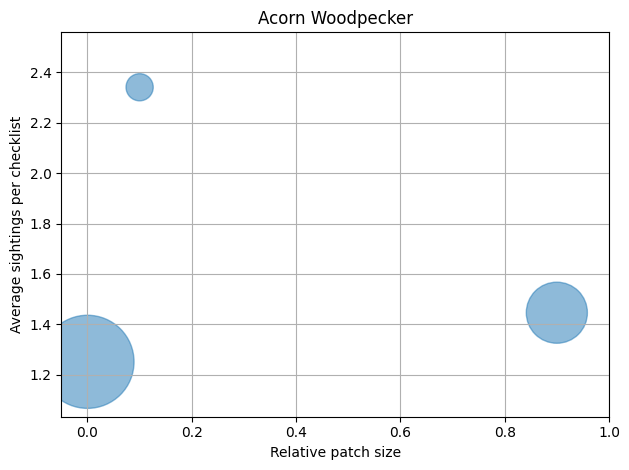

In [13]:

bird = bird_run.get_bird_run(
    "acowoo", "Acorn Woodpecker", run_name="patch_size"
)
plot_bird_ratios_locations(bird, max_checklists=10000)


Number of loactions: 5806
Correlation: -0.9999999999999999
R^2: 1.0
Average on locations with max 10000 checklists


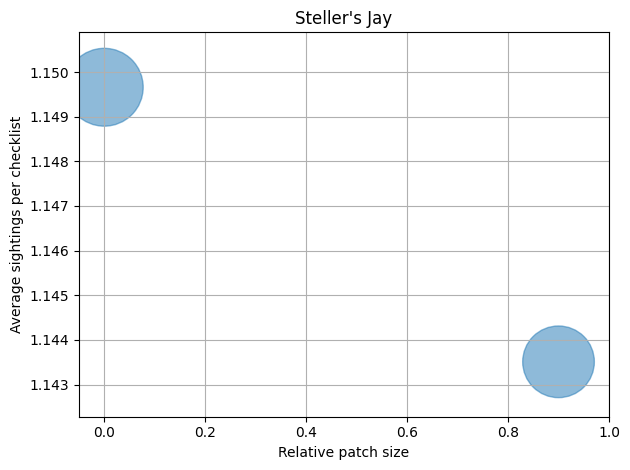

In [14]:

bird = bird_run.get_bird_run(
    "stejay", "Steller's Jay", run_name="patch_size", 
)
plot_bird_ratios_locations(bird, max_checklists=10000)

In [17]:
birds_for_paper = []

birds_for_paper.append(bird_run.get_bird_run(
    "acowoo", "Acorn Woodpecker", run_name="patch_size"))

birds_for_paper.append(bird_run.get_bird_run(
    "stejay", "Steller's Jay", run_name="patch_size"))

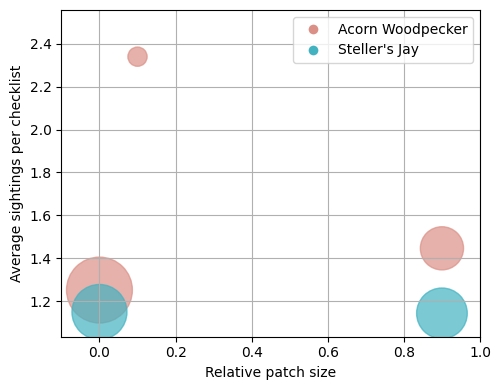

In [20]:
from matplotlib.lines import Line2D  # for legend handle
def plot_birds_ratios(bird_ls, path, max_checklists=100):
    fig, ax = plt.subplots(figsize=(5, 4))

    cmap = colorcet.cm.cyclic_isoluminant_r
    # cmap = plt.cm.inferno
    unique_birds = list(b.nickname for b in bird_ls)
    num_birds = len(unique_birds)
    colors = cmap(np.linspace(0, 1 - 1/num_birds, num_birds))
    colormap = {b:c for b, c in zip(unique_birds, colors)}
    birdname = {b.nickname: b.name for b in bird_ls}
    ylimits = []
    for bird in bird_ls:
        bird_nickname = bird.nickname
        df = pd.read_csv(bird.obs_csv_path)
        # limit to squares where max hab > 0.9
        df = df.loc[lambda r : r["max_hab"] > 0.9]
        df = df.loc[lambda r : r["NumChecklists"] <= max_checklists]
        df["MaxRepopRange"] = df.apply(lambda row : int(row["max_repop"] * 9.999) / 10, axis=1)
        sizes = np.asarray(df.groupby("MaxRepopRange")["Square"].count())
        ys = df.groupby("MaxRepopRange")["BirdRatio"].mean()
        xs = list(df.groupby("MaxRepopRange")["BirdRatio"].indices.keys())
        ymin, ymax = np.min(ys), np.max(ys)
        ylmin, ylmax = ymin - 0.2 * (ymax - ymin), ymax + 0.2 * (ymax - ymin)
        ylimits.append((ylmin, ylmax))
        volume = sizes / 2
        # volume = np.sqrt(sizes**3 / max(sizes))

        ax.scatter(xs, ys, s=volume, color=colormap[bird_nickname], alpha=0.7, label=bird.name)

    ax.set_xlabel("Relative patch size")
    ax.set_ylabel("Average sightings per checklist")
    # ax.set_title('Bird sightings vs. connectivity')

    ax.grid(True)
    fig.tight_layout()

    # add a legend
    handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=c, label=birdname[b], markersize=8) for b, c in colormap.items()]
    ax.legend(handles=handles, loc='upper right')
    plt.xlim((-0.1, 1.0))
    yls, yhs = zip(*ylimits)
    ax.set_ylim(min(yls), max(yhs))

    plt.show()
    
    fig.savefig("Figures/SightingsVsPatchSize.pdf", format="pdf")

plot_birds_ratios(birds_for_paper, "./corr_by_vol.jpg", max_checklists=20000)